In [ ]:
import sys
# 코랩의 경우 깃허브 저장소로부터 utils.py와 vae_utils.py, download_kaggle_data.sh를 다운로드
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/03_vae/03_vae_faces/vae_utils.py
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/scripts/downloaders/download_kaggle_data.sh

--2025-07-27 06:49:20--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2025-07-27 06:49:21 (48.8 MB/s) - ‘utils.py’ saved [771/771]

--2025-07-27 06:49:21--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/03_vae/03_vae_faces/vae_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
    saving
)

from scipy.stats import norm
import pandas as pd

from notebooks.utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

# 파라미터

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

# 데이터 준비

In [ ]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # 캐글-->Setttings-->API-->Create New Token에서
    # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    # from google.colab import files
    # files.upload()
    # !mkdir ~/.kaggle
    # !cp kaggle.json ~/.kaggle/
    # !chmod 600 ~/.kaggle/kaggle.json
    # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    # !kaggle datasets download -d jessicali9530/celeba-dataset
    # !unzip -q celeba-dataset.zip
    #
    # 캐글에서 다운로드가 안 될 경우 역자의 드라이브에서 다운로드할 수 있습니다.
    import gdown
    gdown.download(id='15gJhiDBkltMQz3T97xG-fO4gXTKAWkSB', output='img_align_celeba.zip')
    !unzip -q img_align_celeba.zip
    #
    # output 디렉토리를 만듭니다.
    !mkdir output

Downloading...
From (original): https://drive.google.com/uc?id=15gJhiDBkltMQz3T97xG-fO4gXTKAWkSB
From (redirected): https://drive.google.com/uc?id=15gJhiDBkltMQz3T97xG-fO4gXTKAWkSB&confirm=t&uuid=dd6b6570-920c-47b5-8035-1f5e7201300b
To: /content/img_align_celeba.zip
100%|██████████| 1.43G/1.43G [00:26<00:00, 52.9MB/s]


In [ ]:
# 데이터 로드
train_data = utils.image_dataset_from_directory(
    "./img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files.


In [ ]:
# 데이터 전처리
def preprocess(img):
  img = tf.cast(img, "float32") / 255.0
  return img


train = train_data.map(lambda x : preprocess(x))

In [ ]:
train_sample = sample_batch(train)

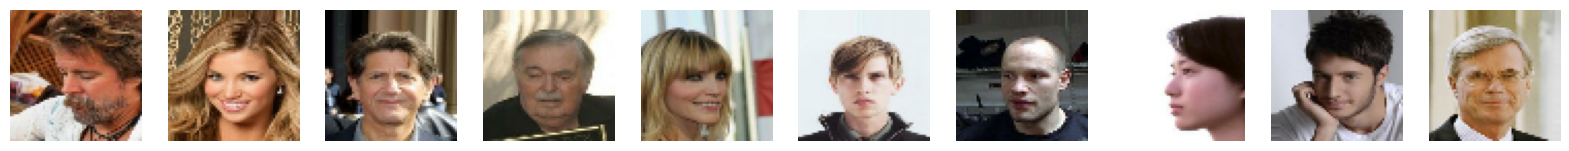

In [ ]:
display(train_sample)

# 변이형 오토인코더 만들기

In [ ]:
# sampling 층
class Sampling(layers.Layer): # keras의 Layer 클래스를 상속한다.
  def call(self, inputs): # z_mean, z_log_var
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch,dim))
    return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [ ]:
# 인코더
encoder_input = layers.Input(
    shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS), name = "encoder_input"
)

x = layers.Conv2D(
    NUM_FEATURES, kernel_size = 3, strides = 2 , padding = "same",
)(encoder_input)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(
    NUM_FEATURES, kernel_size = 3, strides = 2, padding = "same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)

z_mean = layers.Dense(Z_DIM, name = "z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name = "z_log_var")(x)
z = Sampling()([z_mean,z_log_var])

encoder = models.Model(inputs = encoder_input, outputs = [z_mean, z_log_var, z], name = "encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ encoder_input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2, 64)  │     36,928 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 2, 2, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │     51,400 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 253,584 (990.56 KB)

 Trainable params: 252,944 (988.06 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# 디코더
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)

x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 240,131 (938.01 KB)

 Trainable params: 238,979 (933.51 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
mse = tf.keras.losses.MeanSquaredError()

from keras.saving import register_keras_serializable

@register_keras_serializable()
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * mse(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """검증 스텝을 실행합니다."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * mse(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [ ]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

# vae 훈련

In [ ]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# 필요한 경우 이전 가중치 로드
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 92s 48ms/step - kl_loss: 11.5524 - loss: 105.0743 - reconstruction_loss: 93.5219
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 133s 48ms/step - kl_loss: 14.8825 - loss: 71.1267 - reconstruction_loss: 56.2442
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 69s 43ms/step - kl_loss: 15.5176 - loss: 67.7198 - reconstruction_loss: 52.2021
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - kl_loss: 16.2317 - loss: 65.7426 - reconstruction_loss: 49.5108
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - kl_loss: 16.5247 - loss: 64.8344 - reconstruction_loss: 48.3097
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - kl_loss: 16.6278 - loss: 64.4405 - reconstruction_loss: 47.8127
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - kl_loss: 16.7616 - loss: 64.0512 - reconstruction_loss: 47.2896
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - kl_loss: 16.9588 - loss: 63.7545 - reconstruction_loss: 46.7958
Epoch 9/10
1583/1583 ━

In [ ]:
# 최종 모델 저장
vae.save("vae_face.keras")
encoder.save("encoder.keras")
decoder.save("decoder.keras")

In [ ]:
# load models
vae = saving.load_model("vae_face.keras", custom_objects = {"VAE":VAE})
encoder = saving.load_model("encoder.keras")
decoder = saving.load_model("decoder.keras")

# 변이형 오토인코더를 사용한 재구성

In [ ]:
# 테스트 세트에서 일부분을 선택
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

In [ ]:
example_images.shape

(128, 64, 64, 3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
실제 얼굴


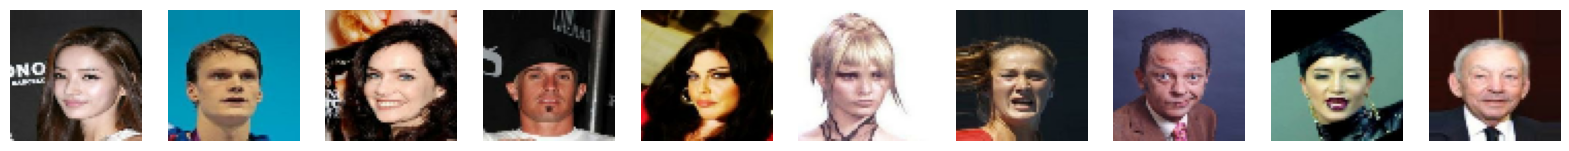

재구성


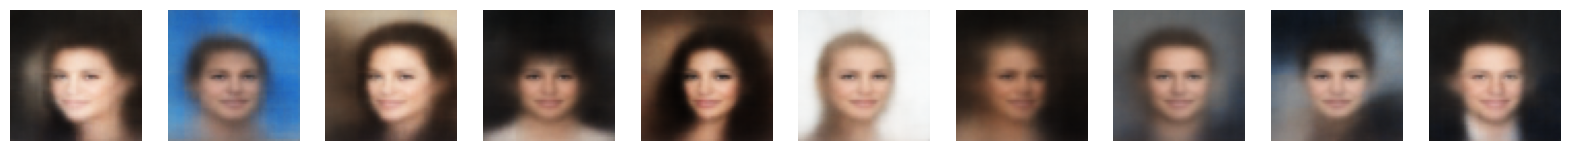

In [ ]:
# 오토인코더 예측을 생성하고 출력
z_mean, Z_log_var, recons = vae.predict(example_images)

print("실제 얼굴")
display(example_images)

print("재구성")
display(recons)

# 잠재 공간 분포

(128, 200)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


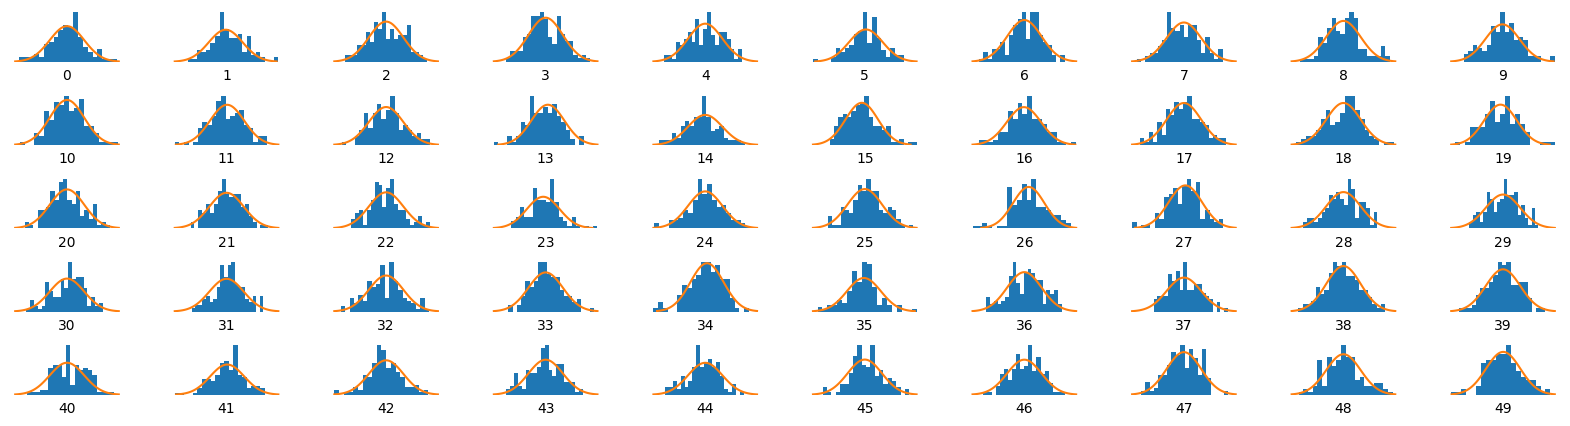

In [ ]:
_, _,z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize = (20,5))
fig.subplots_adjust(hspace = 0.6, wspace = 0.4)

for i in range(50):
  ax = fig.add_subplot(5, 10, i+1)
  ax.hist(z[:,i], density = True, bins = 20)
  ax.axis("off")
  ax.text(
      0.5, -0.35, str(i), fontsize = 10, ha = "center", transform = ax.transAxes
  )
  ax.plot(x, norm.pdf(x))

plt.show()

# 새로운 얼굴 생성

In [ ]:
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size = (grid_width * grid_height, Z_DIM))

recon = vae.decoder(z_sample)

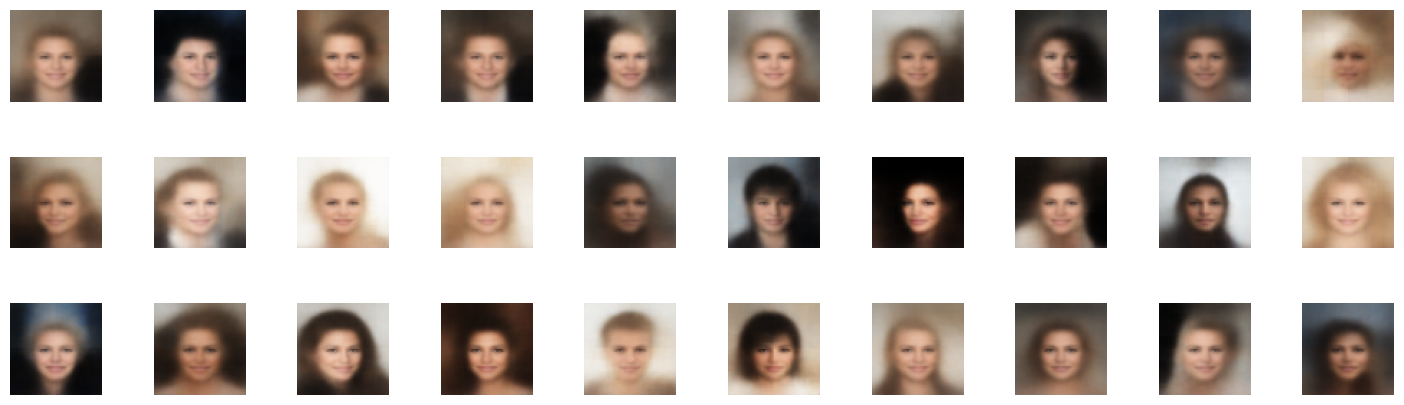

In [ ]:
fig = plt.figure(figsize = (18, 5))
fig.subplots_adjust(hspace = 0.6, wspace = 0.4)

recon.shape
for i in range(recon.shape[0]):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.imshow(recon[i])

plt.show()

# 이미지조작

In [ ]:
# 레이블 데이터셋 로드
attributes = pd.read_csv("./list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
# 레이블이 부착된 얼굴 데이터 로드
LABEL = "Blond_Hair"
labelled_test = utils.image_dataset_from_directory(
    "./img_align_celeba/img_align_celeba",
    labels = attributes[LABEL].tolist(),
    color_mode = 'rgb',
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle =True,
    seed = 42,
    validation_split = 0.2,
    subset = "validation",
    interpolation = "bilinear",
)

labelled = labelled_test.map(lambda x, y : (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [ ]:
# 속성 벡터 찾기
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.05    : 1.433    : 3.267    : 3.267
44    : 2.085    : 1.017    : 2.717    : -0.551
65    : 1.191    : 0.565    : 2.284    : -0.433
87    : 0.84    : 0.399    : 2.024    : -0.26
110    : 0.641    : 0.3    : 1.908    : -0.116
128    : 0.482    : 0.263    : 1.837    : -0.071
150    : 0.45    : 0.207    : 1.782    : -0.056
171    : 0.382    : 0.177    : 1.733    : -0.049
197    : 0.382    : 0.161    : 1.695    : -0.037
218    : 0.289    : 0.15    : 1.686    : -0.009
241    : 0.292    : 0.141    : 1.665    : -0.021
260    : 0.246    : 0.117    : 1.648    : -0.017
282    : 0.248    : 0.11    : 1.624    : -0.024
302    : 0.2    : 0.098    : 1.588    : -0.035
317    : 0.162    : 0.102    : 1.574    : -0.015
337    : 0.198    : 0.087    : 1.574    : 0.001
356    : 0.155    : 0.081    : 1.56    : -0.015
377    : 0.175    : 0.074    : 1.538    : -0.021
395    : 0.156    : 0.069    : 1.511    : -0.028
415    : 0.154  

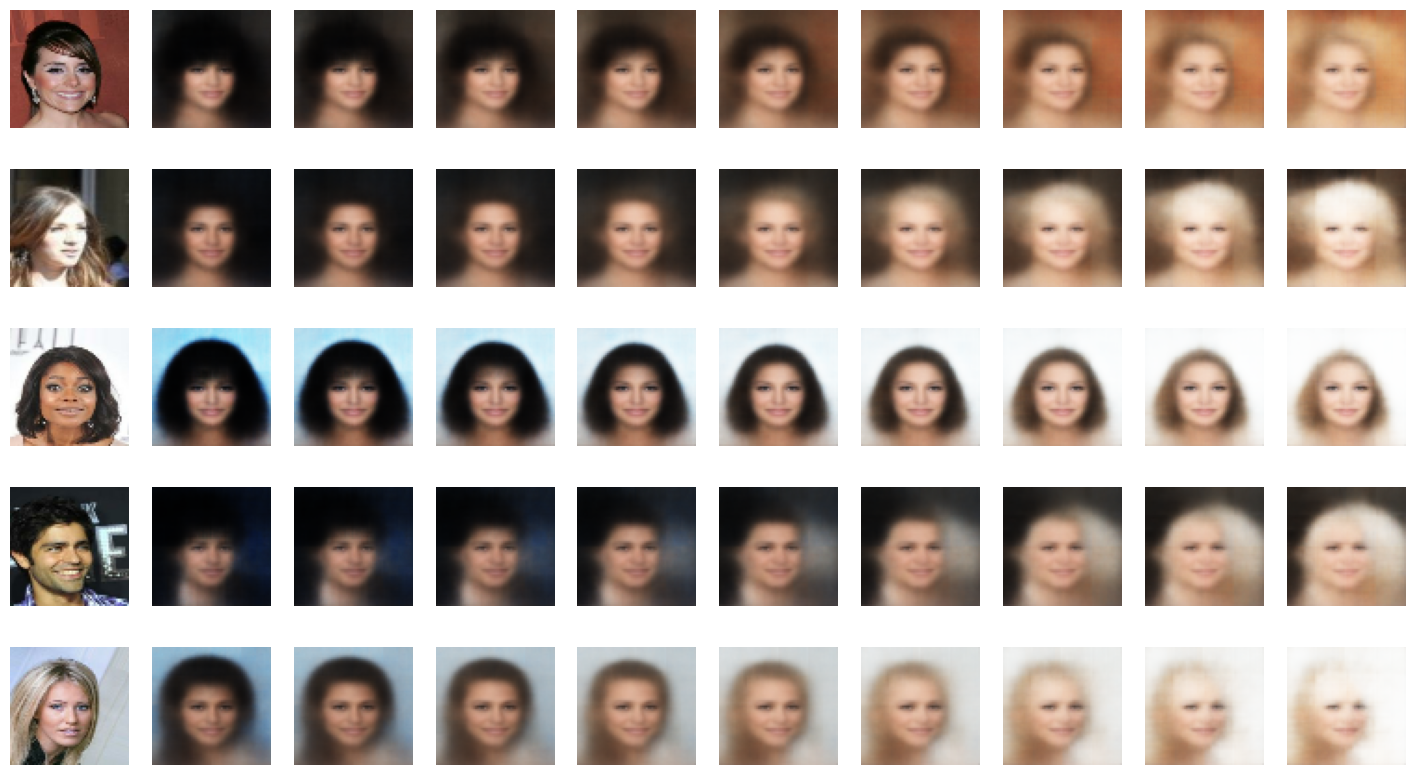

In [ ]:
add_vector_to_images(labelled, vae, attribute_vec)

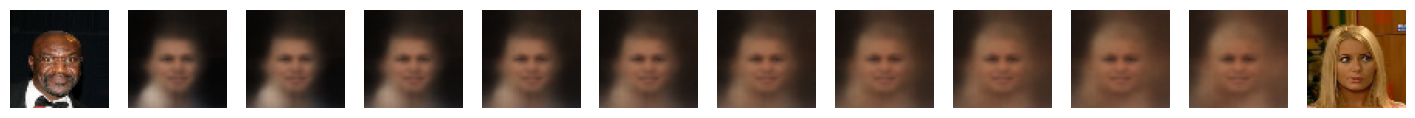

In [ ]:
morph_faces(labelled, vae)